In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc

/usr/local/anaconda3/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
#MwMote
combine_car_features = pd.read_csv('finalPreprocessBinaryTogether.csv')
combine_car_label = pd.read_csv('label.csv')
print(combine_car_features.shape)
print(combine_car_label.shape)

#add columns to existing dataframe
combine_car_features['FraudFound']=combine_car_label 

#shuffle the data.
new_combine_features = combine_car_features.set_index(np.random.permutation(combine_car_features.index))

#now divide the feature and label
new_label = new_combine_features['FraudFound']

#drop the Fraud Found lable
new_combine_features.drop(['FraudFound'],inplace=True,axis=1)

(28992, 52)
(28992, 1)


In [3]:
#cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score


scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

kfold = model_selection.KFold(n_splits=10, random_state=100)
model = svm.SVC(kernel='rbf')

results = model_selection.cross_validate(estimator=model,X=new_combine_features,y=new_label,cv=kfold,scoring=scoring)

print(np.mean(results['test_accuracy']))
print(np.mean(results['test_precision']))
print(np.mean(results['test_recall']))
print(np.mean(results['test_f1_score']))


/usr/local/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/lib/python3.5/site-packages/sklearn/svm/

0.771222264515
0.550518841621
0.892296617192
0.584070904823


/usr/local/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/lib/python3.5/site-packages/sklearn/svm/

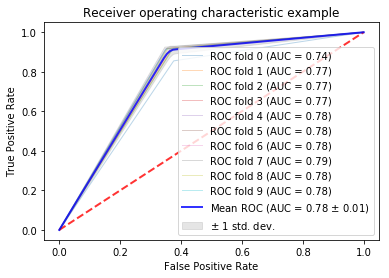

Accuracy: 77.5043311677
Precision: 71.6447758507
Sensitivity: 91.0253397111
Specificity: 63.9833226244
F1_score: 80.1778575455


In [5]:
# Run classifier with cross-validation and plot ROC curves
from sklearn.model_selection import StratifiedKFold
from scipy import interp


cv = StratifiedKFold(n_splits=10)
classifier = svm.SVC(kernel='rbf') 
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0

new_combine_features= pd.DataFrame(new_combine_features).values
new_label= pd.Series(new_label).values

#plot of ROC curve for cross validation
accuracy= []
precision= []
sensitivity= []
specificity= []
f1score= []
classifier.probability= True
for train, test in cv.split(new_combine_features, new_label):
    probas_ = classifier.fit(new_combine_features[train], new_label[train]).predict_proba(new_combine_features[test])
    j= 0
    for j in range(probas_.shape[0]):
        if (probas_[j,1]>0.5):
            probas_[j,1]= 1
        else:
            probas_[j,1]= 0

      
    cm = confusion_matrix(new_label[test],probas_[:,1])
    TN, FP, FN, TP = cm.ravel()
    acc= (TP+TN)/(TP+FP+FN+TN)*100
    prec= TP/(TP+FP)*100
    sens= TP/(TP+FN)*100
    spec= TN/(TN+FP)*100
    f1= (2 * prec * sens)/(prec + sens)
    
    accuracy.append(acc)
    precision.append(prec)
    sensitivity.append(sens)
    specificity.append(spec)
    f1score.append(f1)
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(new_label[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

print("Accuracy:",np.mean(accuracy))
print("Precision:",np.mean(precision))
print("Sensitivity:",np.mean(sensitivity))
print("Specificity:",np.mean(specificity))
print("F1_score:",np.mean(f1score))


In [7]:
#DT tress with out class imblance.
#random forest without smote with cross validation
car_df = pd.read_csv('newCardata.csv')
car_features = pd.read_csv('finalDataPreprocessBinary.csv')
#change the label of the data
labelNo = LabelEncoder()
car_df['FraudFound'] = labelNo.fit_transform(car_df['FraudFound'].astype('str'))
car_label = car_df['FraudFound']
print(car_label.shape)


cv = StratifiedKFold(n_splits=10)
classifier = svm.SVC(kernel='rbf') 
classifier.probability= True
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
accuracy= []
precision= []
sensitivity= []
specificity= []
f1score= []

car_features= pd.DataFrame(car_features).values
car_label= pd.Series(car_label).values



for train, test in cv.split(car_features, car_label):
    probas_ = classifier.fit(car_features[train], car_label[train]).predict_proba(car_features[test])
    j= 0
    for j in range(probas_.shape[0]):
        if (probas_[j,1]>0.5):
            probas_[j,1]= 1
        else:
            probas_[j,1]= 0

      
    cm = confusion_matrix(car_label[test],probas_[:,1])
    TN, FP, FN, TP = cm.ravel()
    acc= (TP+TN)/(TP+FP+FN+TN)*100
    prec= TP/(TP+FP)*100
    sens= TP/(TP+FN)*100
    spec= TN/(TN+FP)*100
    f1= (2 * prec * sens)/(prec + sens)
    
    accuracy.append(acc)
    precision.append(prec)
    sensitivity.append(sens)
    specificity.append(spec)
    f1score.append(f1)
    
print("Accuracy:",np.mean(accuracy))
print("Precision:",np.mean(precision))
print("Sensitivity:",np.mean(sensitivity))
print("Specificity:",np.mean(specificity))
print("F1_score:",np.mean(f1score))


(15419,)


/usr/local/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/lib/python3.5/site-packages/sklearn/svm/

Accuracy: 94.1371119569
Precision: 68.380952381
Sensitivity: 3.79266012155
Specificity: 99.8896218557
F1_score: 7.17896936969
